In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Lectura de datos

In [4]:
## https://www.kaggle.com/datasets/bobnau/daily-website-visitors/code
daily_website_df = pd.read_csv("../../kats/data/daily-website-visitors.csv")
daily_website_df.head()
# Function to remove commas
def remove_commas(x):
    return float(x.replace(',', ''))
# Apply the preprocessing functions

daily_website_df['Date'] = pd.to_datetime(daily_website_df['Date'])
daily_website_df['Page.Loads'] = daily_website_df['Page.Loads'].apply(lambda x : remove_commas(x))
daily_website_df['Unique.Visits'] = daily_website_df['Unique.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['First.Time.Visits'] = daily_website_df['First.Time.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Returning.Visits'] = daily_website_df['Returning.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Day.Of.Week']
df_mask=daily_website_df['Day.Of.Week']==2
daily_website_df_monday = daily_website_df[df_mask]


daily_website_df.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]

daily_website_df_monday.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df_monday.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]



## First study

In [5]:

daily_website_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PageLoads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
UniqueVisits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
FirstTimeVisits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0


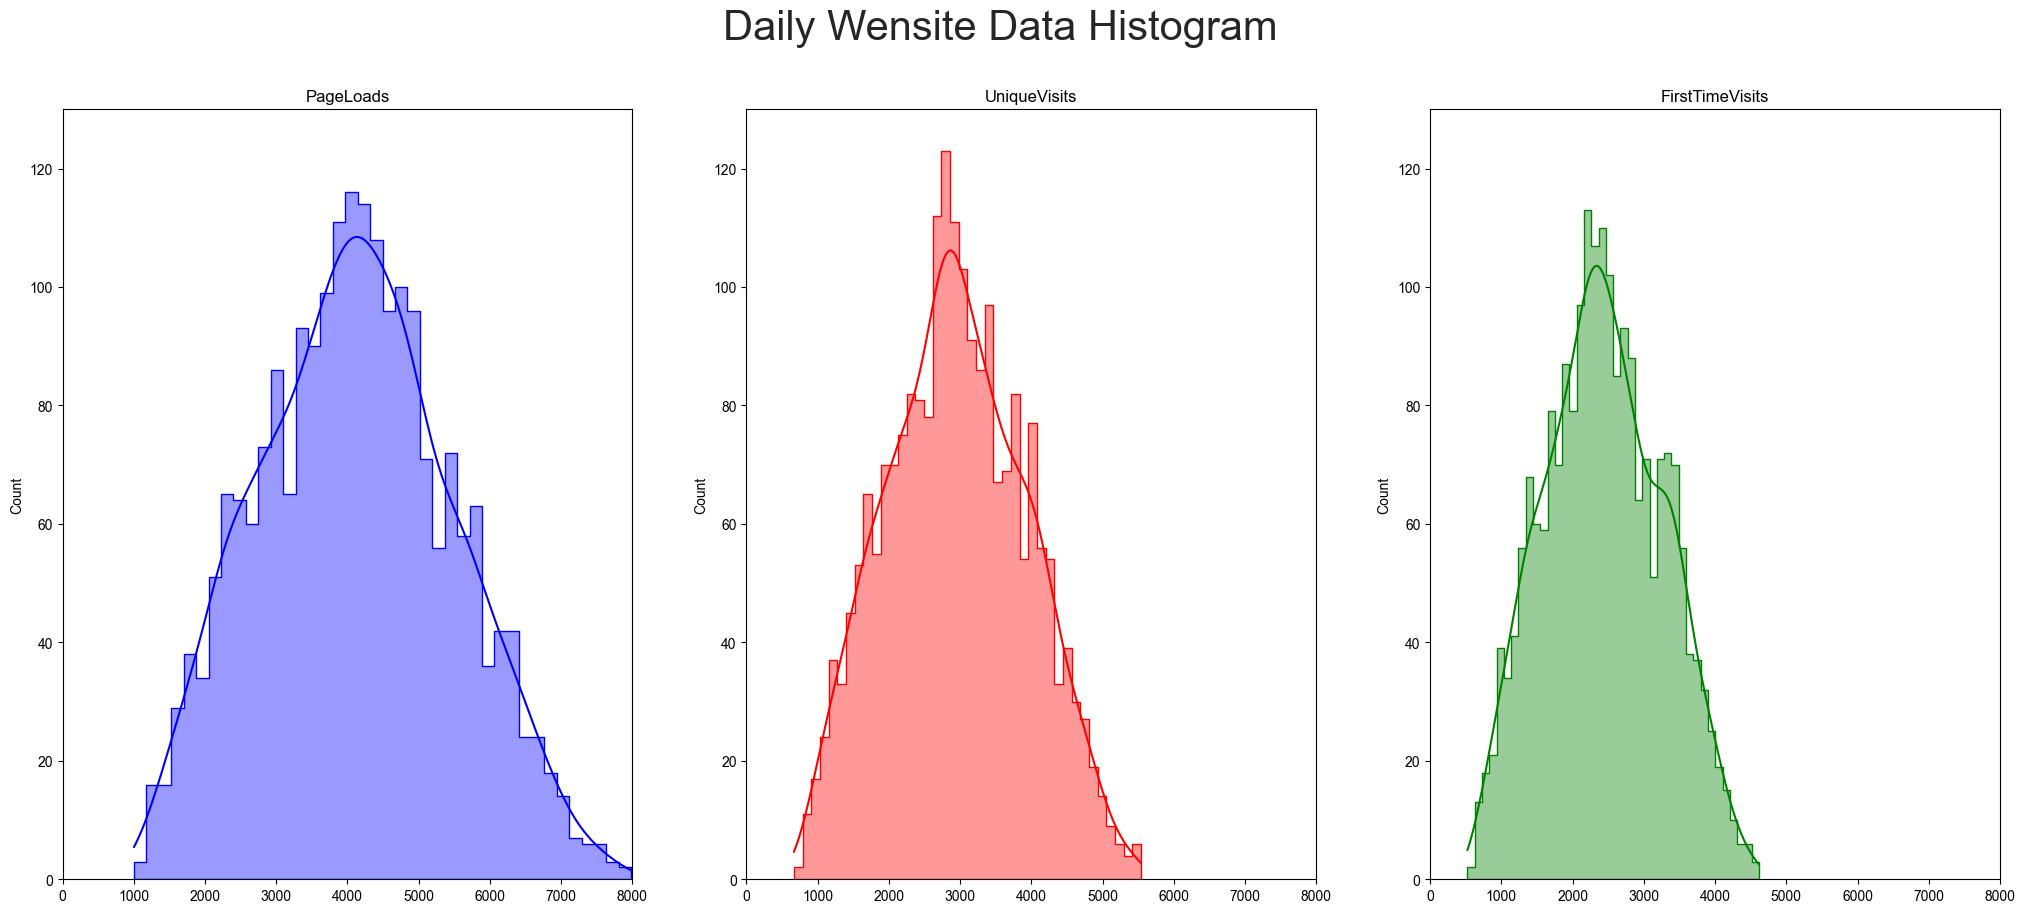

In [6]:
import seaborn as sns
colors = ['blue', 'red','green']

fig, ax = plt.subplots(1,3)



def hist(var,i):
    sns.set_style("darkgrid")
    # sns.limit(x=(0, 8000), y=(0, 130))
    p = sns.histplot(data = daily_website_df, color=colors[i], x = var,element='step' ,alpha = 0.4,kde = True, bins=40, ax = ax[i] )
    p.set(title= var)
    p.set_xlim(0,8000)
    p.set_ylim(0,130)
    p.set_xlabel('')

i = 0
for var in daily_website_df.columns.to_list()[1:4]:
    # print(var)
    hist(var,i)
    i = i+1

# fig.tight_layout()
fig.set_size_inches(25, 10)
fig.suptitle('Daily Wensite Data Histogram', fontsize = 30)

plt.savefig('../../images/DWD_hist', bbox_inches='tight')

## First visualitation

In [7]:
daily_website_ts = TimeSeriesData(daily_website_df)

daily_website_ts_monday = TimeSeriesData(daily_website_df_monday)

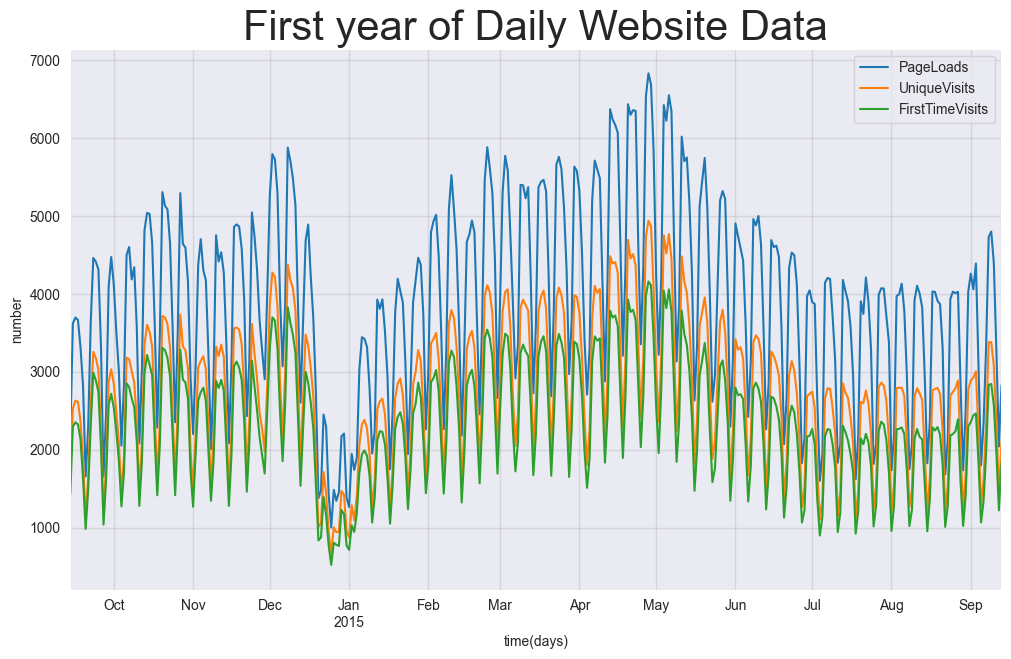

In [8]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts[0:365].plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.title('First year of Daily Website Data', fontsize = 30)
plt.xlabel('time(days)')
plt.ylabel('number')
plt.savefig('../../images/DWD_first_year', bbox_inches = 'tight')

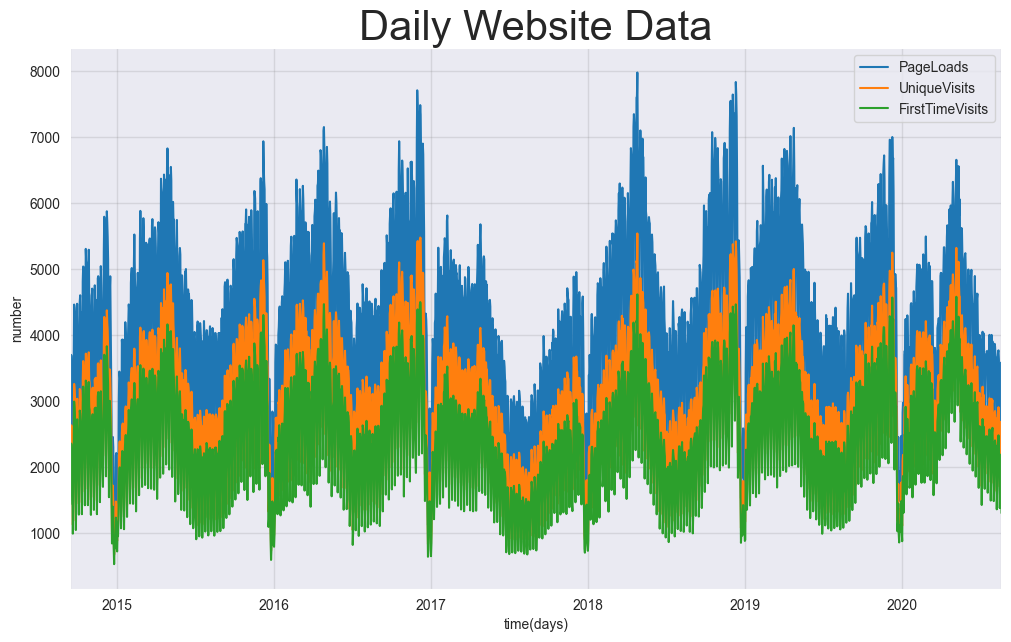

In [9]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts.plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
# fig = plt.figure()
plt.title('Daily Website Data', fontsize = 30)
plt.xlabel('time(days)')
plt.ylabel('number')
plt.savefig('../../images/DWD', bbox_inches = 'tight')

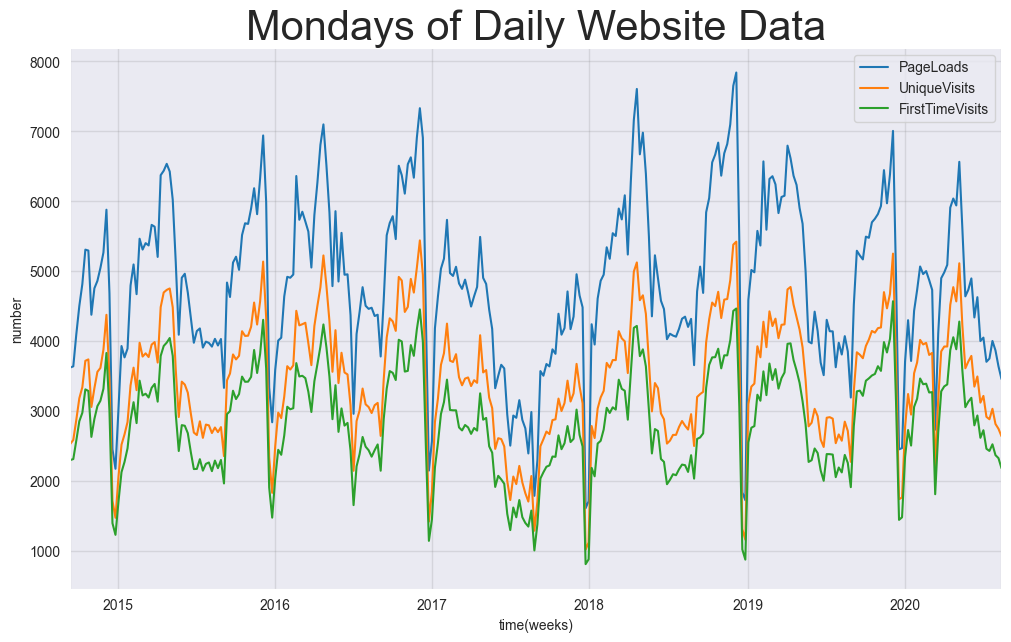

In [10]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts_monday.plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.title('Mondays of Daily Website Data', fontsize = 30)
plt.xlabel('time(weeks)')
plt.ylabel('number')
plt.savefig('../../images/DWD_mondays', bbox_inches = 'tight')

In [11]:
daily_website_PL_ts = TimeSeriesData(daily_website_df.drop(['UniqueVisits','FirstTimeVisits'], axis=1))
daily_website_PL_ts

daily_website_UV_ts = TimeSeriesData(daily_website_df.drop(['PageLoads','FirstTimeVisits'], axis=1))
daily_website_UV_ts

daily_website_FTV_ts = TimeSeriesData(daily_website_df.drop(['PageLoads','UniqueVisits'], axis=1))
daily_website_FTV_ts

,time,FirstTimeVisits
0,2014-09-14,1430.0
1,2014-09-15,2297.0
2,2014-09-16,2352.0
3,2014-09-17,2327.0
4,2014-09-18,2130.0
...,...,...
2162,2020-08-15,1373.0
2163,2020-08-16,1686.0
2164,2020-08-17,2181.0
2165,2020-08-18,2184.0


# First comparative : PageLoads

In [12]:
## HYPERPARAMETERS
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData


from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

ts = daily_website_PL_ts

## SARIMA

In [13]:
from kats.models.sarima import SARIMAModel, SARIMAParams
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(ts))

train_ts = ts[0:split]
test_ts = ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    sarima_params = SARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = SARIMAModel(train_ts, sarima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'p': 2, 'd': 1, 'q': 2}

In [14]:
# create SARIMA param class
sarima_params = SARIMAParams(
    p = 2, 
    d = 1, 
    q = 2, 
    trend = 'ct', #both linear or constant
    seasonal_order=(0,0,0,7) # Becouse the data have a weekly behaivour
    )

## Linear y Cuadrático : sin parámetros

In [15]:
from kats.models.linear_model import LinearModelParams, LinearModel
from kats.models.quadratic_model import QuadraticModelParams, QuadraticModel
lin_params = LinearModelParams()
qua_params = QuadraticModelParams()

## Stlf

In [16]:
from kats.models.stlf import STLFModel, STLFParams
parameters_grid_search = [
{
    "name": "method",
    "type": "choice",
    "values": ['theta','linear','quadratic'] ,
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "m",
    "type": "choice",
    "values": [7,30,365],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    stlf_params =STLFParams(
        method = params['method'],
        m = params['m']
    )
    model =STLFModel(train_ts, stlf_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'method': 'theta', 'm': 7}

In [17]:
stlf_params = STLFParams(
    method = 'theta',
    m = 7
    )

## Harmonic Regression

In [18]:
from kats.models.harmonic_regression import HarmonicRegressionModel, HarmonicRegressionParams
parameters_grid_search = [
{
    "name": "period",
    "type": "choice",
    "values": [7,30,360] ,
    "value_type": "float",
    "is_ordered": True,
},
{
    "name": "fourier_order",
    "type": "choice",
    "values": [4,5,6,7,8],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    hg_params =HarmonicRegressionParams(
        period = params['period'],
        fourier_order = params['fourier_order']
    )
    model =HarmonicRegressionModel(train_ts, hg_params)
    model.fit()
    model_pred = model.predict(dates  = test_ts.time)
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'period': 30.0, 'fourier_order': 4}

In [19]:
hr_params =HarmonicRegressionParams(
        period = 30,
        fourier_order = 4
    )

## Evaluación de modelos

In [20]:
from kats.utils.backtesters import BackTesterSimple

In [21]:

backtester_simple_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']

###############################################################################

backtester_simple_sarima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= sarima_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=SARIMAModel)

backtester_simple_sarima.run_backtest()

backtester_simple_errors['sarima'] = {}
for error, value in backtester_simple_sarima.errors.items():
    backtester_simple_errors['sarima'][error] = value

In [22]:
###############################################################################
backtester_simple_lin = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = lin_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= LinearModel)

backtester_simple_lin.run_backtest()

backtester_simple_errors['linear'] = {}
for error, value in backtester_simple_lin.errors.items():
    backtester_simple_errors['linear'][error] = value

In [23]:
###############################################################################
backtester_simple_qua = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = qua_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= QuadraticModel)

backtester_simple_qua.run_backtest()

backtester_simple_errors['quadratic'] = {}
for error, value in backtester_simple_qua.errors.items():
    backtester_simple_errors['quadratic'][error] = value




In [24]:
###############################################################################
backtester_simple_stlf = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = stlf_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= STLFModel)

backtester_simple_stlf.run_backtest()

backtester_simple_errors['stlf'] = {}
for error, value in backtester_simple_stlf.errors.items():
    backtester_simple_errors['stlf'][error] = value


pd.DataFrame.from_dict(backtester_simple_errors) 

,sarima,linear,quadratic,stlf
mae,9.580165e+02,1.023986e+03,1.307677e+03,756.565262
mape,2.830752e-01,3.261193e-01,4.302548e-01,0.200126
mase,1.456019e+00,1.556281e+00,1.987441e+00,1.149848
mse,1.381966e+06,1.569372e+06,2.468250e+06,912806.736375
rmse,1.175571e+03,1.252746e+03,1.571066e+03,955.409198
smape,2.435180e-01,2.587600e-01,3.134221e-01,0.193308


## Ensemble

In [25]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
model_ensemble_params = EnsembleParams(
            [
                BaseModelParams("sarima",sarima_params),
                BaseModelParams("linear", lin_params),
                BaseModelParams("quadratic", qua_params)
                # BaseModelParams("stlf", stlf_params)
            ]
        )

from kats.models.ensemble.bates_granger_ensemble import BatesGrangerEnsemble
from kats.models.ensemble.weighted_avg_ensemble import WeightedAvgEnsemble
from kats.models.ensemble.mean_ensemble import MeanEnsembleModel
from kats.models.ensemble.median_ensemble import MedianEnsembleModel


In [26]:
backtester_ensemble_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']
###############################################################################
backtester_ensemble_median = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20,
    model_class=MedianEnsembleModel)

backtester_ensemble_median.run_backtest()

backtester_ensemble_errors['median'] = {}
for error, value in backtester_ensemble_median.errors.items():
    backtester_ensemble_errors['median'][error] = value
###############################################################################




In [27]:
backtester_ensemble_mean = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=MeanEnsembleModel)

backtester_ensemble_mean.run_backtest()

backtester_ensemble_errors['mean'] = {}
for error, value in backtester_ensemble_mean.errors.items():
    backtester_ensemble_errors['mean'][error] = value
###############################################################################

In [28]:
backtester_ensemble_weighted_average = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=WeightedAvgEnsemble)

backtester_ensemble_weighted_average.run_backtest()

backtester_ensemble_errors['weighted_average'] = {}
for error, value in backtester_ensemble_weighted_average.errors.items():
    backtester_ensemble_errors['weighted_average'][error] = value
###############################################################################

In [29]:
backtester_ensemble_bates_granger = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=BatesGrangerEnsemble)

backtester_ensemble_bates_granger.run_backtest()

backtester_ensemble_errors['bates&granger'] = {}
for error, value in backtester_ensemble_bates_granger.errors.items():
    backtester_ensemble_errors['bates&granger'][error] = value

pd.DataFrame.from_dict(backtester_ensemble_errors) 

,median,mean,weighted_average,bates&granger
mae,1.038028e+03,1.051422e+03,1.043585e+03,1.040667e+03
mape,3.304661e-01,3.366288e-01,3.330893e-01,3.318792e-01
mase,1.577622e+00,1.597979e+00,1.586067e+00,1.581633e+00
mse,1.604634e+06,1.648746e+06,1.624946e+06,1.615634e+06
rmse,1.266741e+03,1.284035e+03,1.274734e+03,1.271076e+03
smape,2.617099e-01,2.640848e-01,2.624476e-01,2.618719e-01


In [30]:
pd.DataFrame.from_dict(backtester_ensemble_errors).round(2)


,median,mean,weighted_average,bates&granger
mae,1038.03,1051.42,1043.58,1040.67
mape,0.33,0.34,0.33,0.33
mase,1.58,1.60,1.59,1.58
mse,1604633.53,1648745.74,1624946.30,1615634.43
rmse,1266.74,1284.03,1274.73,1271.08
smape,0.26,0.26,0.26,0.26


In [31]:
pd.DataFrame.from_dict(backtester_simple_errors).round(2)

,sarima,linear,quadratic,stlf
mae,958.02,1023.99,1307.68,756.57
mape,0.28,0.33,0.43,0.20
mase,1.46,1.56,1.99,1.15
mse,1381966.01,1569372.07,2468249.75,912806.74
rmse,1175.57,1252.75,1571.07,955.41
smape,0.24,0.26,0.31,0.19


In [32]:
var_simple = pd.DataFrame.from_dict(backtester_simple_errors).T.var().values
print(var_simple.round(2))
var_ensemble = pd.DataFrame.from_dict(backtester_ensemble_errors).T.var().values
print(var_ensemble.round(2))

coc = var_simple/var_ensemble

df = pd.DataFrame(index = ['mae', 'mape', 'mase', 'mse', 'rmse', 'smape'], columns=['Simple','Ensemble','Cociente de var'] )#, data=[var_simple,var_ensemble,coc])
df['Simple'] = var_simple.round(4)
df['Ensemble'] = var_ensemble.round(4)
df['Cociente de var'] = coc.round()

df

[5.19095600e+04 1.00000000e-02 1.20000000e-01 4.24475495e+11
 6.49679200e+04 0.00000000e+00]
[3.35700000e+01 0.00000000e+00 0.00000000e+00 3.52416549e+08
 5.41300000e+01 0.00000000e+00]


,Simple,Ensemble,Cociente de var
mae,5.190956e+04,3.357020e+01,1546.0
mape,9.200000e-03,0.000000e+00,1320.0
mase,1.199000e-01,1.000000e-04,1546.0
mse,4.244755e+11,3.524165e+08,1204.0
rmse,6.496792e+04,5.413020e+01,1200.0
smape,2.400000e-03,0.000000e+00,2078.0


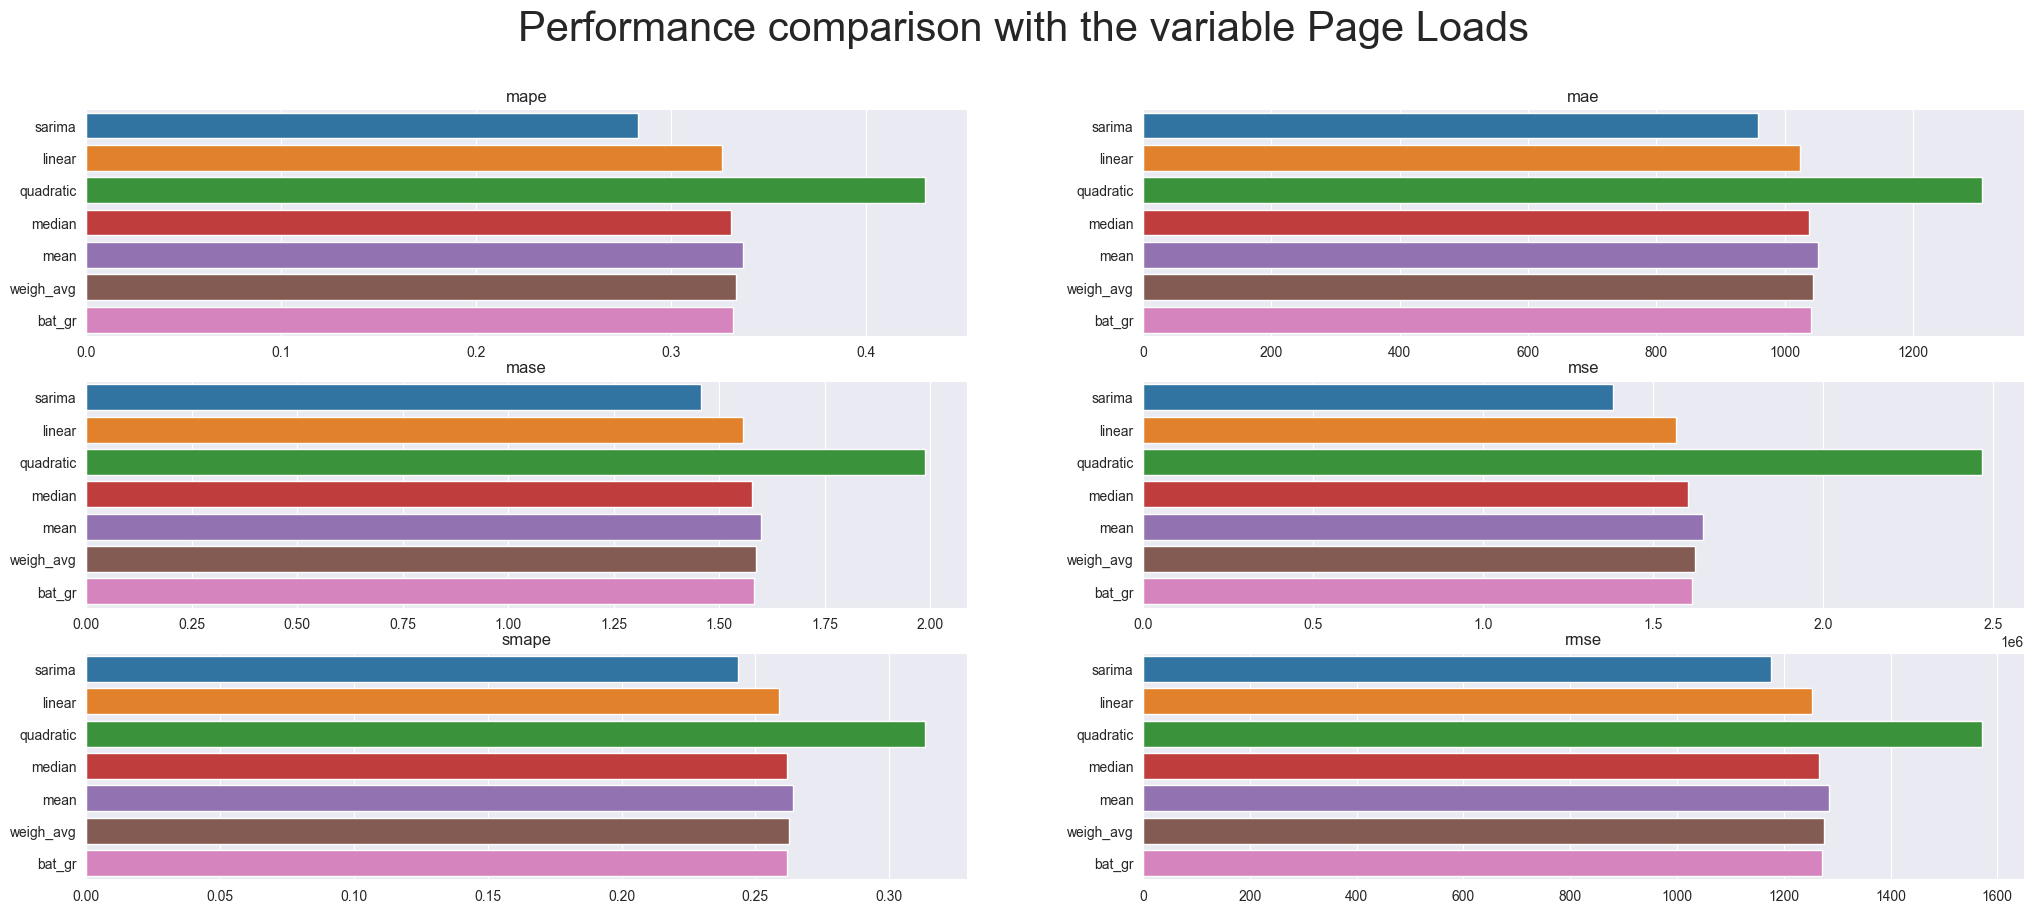

In [33]:
# TODOS JUNTOS 
df_complete = pd.concat([pd.DataFrame.from_dict(backtester_simple_errors).drop(['stlf'], axis=1),pd.DataFrame.from_dict(backtester_ensemble_errors)], axis=1).T

# df_complete.index = ['s','a','p','h','t','me','wa','bg']
# df_complete.index[6] = 'weigh_avg'
# df_complete.index[7] = 'bat_gr'
df_complete.index = ['sarima', 'linear', 'quadratic','median','mean','weigh_avg', 'bat_gr']

import seaborn as sns
sns.set_style("darkgrid")
def comparative_barplot(err,i,j):
    
    p = sns.barplot(
        x = err,
        y = df_complete.index,
        data = df_complete,
        ax = ax[i][j]
        
    )
    p.set(title= err)
    p.set_xlabel('')

error = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots(3, 2)
# plt.rc('font', size = 15)
# fig.suptitle('Comparison of the different types of errors', fontsize = 40, fontfamily ='DejaVu Sans' )


i = 0
for e in error[0:3]:
    comparative_barplot(e,i,0) 
    i = i+1

i = 0
for e in error[3:7]:
    comparative_barplot(e,i,1) 
    i = i+1

# fig.tight_layout()
fig.set_size_inches(25, 10)
fig.suptitle('Performance comparison with the variable Page Loads', fontsize = 30)

plt.savefig('../../images/DWD_PL_comparative_errors', bbox_inches='tight')